In [ ]:
import pandas as pd
from sklearn import linear_model
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
def linreg(x, y):
  model = linear_model.LinearRegression()
  x = np.asarray(x).reshape(-1,1)
  model.fit(x,y)
  r_sq = model.score(x,  y)
  coeff = model.coef_[0]
  intercept = model.intercept_
  return r_sq, coeff, intercept
  
def rand_jitter(arr):
    stdev = .01 * (max(arr) - min(arr))
    return arr + np.random.randn(len(arr)) * stdev

# Load and show the data

In [ ]:
url = 'https://raw.githubusercontent.com/fivethirtyeight/data/master/candy-power-ranking/candy-data.csv'
df = pd.read_csv(url)
df.head()

,competitorname,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent
0,100 Grand,1,0,1,0,0,1,0,1,0,0.732,0.860,66.971725
1,3 Musketeers,1,0,0,0,1,0,0,1,0,0.604,0.511,67.602936
2,One dime,0,0,0,0,0,0,0,0,0,0.011,0.116,32.261086
3,One quarter,0,0,0,0,0,0,0,0,0,0.011,0.511,46.116505
4,Air Heads,0,1,0,0,0,0,0,0,0,0.906,0.511,52.341465


**Clarifying the term winpercent and inital observations of the dataset**

In the blogpost 'The Ultimate Halloween Candy Power Ranking' the author defined the meaning of winpercent, as seen in the last column of the dataset. The column is derived by pitting one sort of candy brand (like Air Heads) against another sort of any type. Such an experiment is repeated with different individuals, where the better tasting candy wins.
The winpercent is then computed by the number of times the candy won, over all times it was challenged by an individual from the sample crowd. In this case, out of all the times Air Heads was challenged, only 52% of the time in the test did people pick this candy against other candies. 

Sugar percentile and price percentile, are similar to win percent is considered to be quantitative data.


The other features describe how the candy is like are categorical data and are considered as qualitative data.




# Sort table by winpercent to see which candy is the most popular

In [ ]:
df.sort_values(by=['winpercent'], ascending=False) # sort table by winpercent in descending order

,competitorname,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent
52,ReeseÕs Peanut Butter cup,1,0,0,1,0,0,0,0,0,0.720,0.651,84.180290
51,ReeseÕs Miniatures,1,0,0,1,0,0,0,0,0,0.034,0.279,81.866257
79,Twix,1,0,1,0,0,1,0,1,0,0.546,0.906,81.642914
28,Kit Kat,1,0,0,0,0,1,0,1,0,0.313,0.511,76.768600
64,Snickers,1,0,1,1,1,0,0,1,0,0.546,0.651,76.673782
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26,Jawbusters,0,1,0,0,0,0,1,0,1,0.093,0.511,28.127439
72,Super Bubble,0,1,0,0,0,0,0,0,0,0.162,0.116,27.303865
12,Chiclets,0,1,0,0,0,0,0,0,1,0.046,0.325,24.524988
7,Boston Baked Beans,0,0,0,1,0,0,0,0,1,0.313,0.511,23.417824


Judging from winpercent, the most popular candy is Reese's Peanut Butter cup.

# Check for number of distinct combined features

In [ ]:
dummy_encoded_features = df[['chocolate', 'fruity', 'caramel', 'peanutyalmondy','nougat', 'crispedricewafer', 'hard', 'bar', 'pluribus']]

# add 'no_features' column 
dummy_encoded_features['no_features'] = np.zeros(85)
dummy_encoded_features.loc[((dummy_encoded_features == 0).all(axis=1)), 'no_features'] = 1

# add column for counting frequency
dummy_encoded_features['frequency'] = np.ones(85)

# add winpercent column
dummy_encoded_features['winpercent'] = df['winpercent']

freq_feature_table = dummy_encoded_features.groupby(['chocolate', 'fruity', 'caramel', 'peanutyalmondy','nougat', 'crispedricewafer', 'hard', 'bar', 'pluribus', 'no_features'], as_index=False).agg({'frequency':'size', 'winpercent':'mean'}).rename(columns={'winpercent':'mean_winpercent'})
freq_feature_table.sort_values(by=['frequency', 'mean_winpercent'], ascending=False).reset_index(drop=True)

<ipython-input-5-65886e735b7a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dummy_encoded_features['no_features'] = np.zeros(85)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
<ipython-input-5-65886e735b7a>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,no_features,frequency,mean_winpercent
0,0,1,0,0,0,0,0,0,1,0.0,19,46.662800
1,0,1,0,0,0,0,1,0,1,0.0,7,42.136329
2,1,0,0,0,0,0,0,0,1,0.0,6,49.585871
3,0,1,0,0,0,0,0,0,0,0.0,5,43.882512
4,0,1,0,0,0,0,1,0,0,0.0,5,38.417954
5,1,0,0,0,0,0,0,1,0,0.0,4,53.302470
6,1,0,0,1,0,0,0,0,0,0.0,3,79.644816
7,1,0,0,1,0,0,0,0,1,0.0,3,71.461276
8,1,0,0,0,0,1,0,1,0,0.0,3,68.507920
9,1,0,0,1,0,0,0,1,0,0.0,3,58.536546


There are 29 distinct combinations of features in the sample of 86 different candy brands.

# Investigate quantitative data: Sugar percentile and Price percentile and its relations to a candy's popularity.

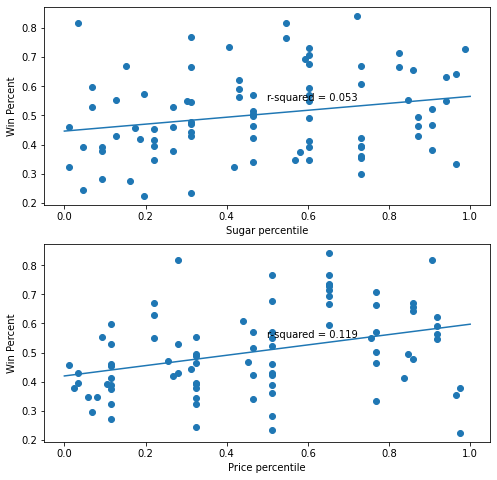

In [ ]:
price_r_sq, price_coeff, price_intercept = linreg(df['pricepercent'], df['winpercent']/100)
sugar_r_sq, sugar_coeff, sugar_intercept = linreg(df['sugarpercent'], df['winpercent']/100)

fig, ax = plt.subplots(2, figsize=(8,8))

# scatter plot of sugar influence against popularity
ax[0].scatter(df['sugarpercent'], df['winpercent']/100)
ax[0].set_xlabel('Sugar percentile') # independent variable
ax[0].set_ylabel('Win Percent') #dependent variable

#plot regression line for sugar and winpercent
x = np.arange(0,1.1,0.1)
y = x*sugar_coeff + sugar_intercept
ax[0].plot(x,y)
ax[0].annotate("r-squared = {:.3f}".format(sugar_r_sq), (0.5, 0.55))



# scatter plot for price influence against popularity
ax[1].scatter(df['pricepercent'], df['winpercent']/100)
ax[1].set_xlabel('Price percentile')
ax[1].set_ylabel('Win Percent')

#plot regression line for price and winpercent
x = np.arange(0,1.1,0.1)
y = x*price_coeff + price_intercept
ax[1].plot(x,y)
ax[1].annotate("r-squared = {:.3f}".format(price_r_sq), (0.5, 0.55))


plt.show()

Due to low r-squared values, the variables sugarpercentile to win percent and price percentile to win percent show weak correlation. Hence, we conclude that the popularity of a candy is unrelated to how much sugar is in the candy, nor is it related to how expensive the candy is. This is in line with the conclusion from the blog post 'The Ultimate Halloween Candy Power Ranking', where the dataset comes from.

# Problem Type: Multiple Regression using dummy encoded multi-categorical variables using Ordinary Least Squares Regression

there are also other types like weighted least squares (WLS), generalized least squares (GLS), and feasible generalized least squares with autocorrelated AR(p) errors.

## Visualise how feature points are related in space

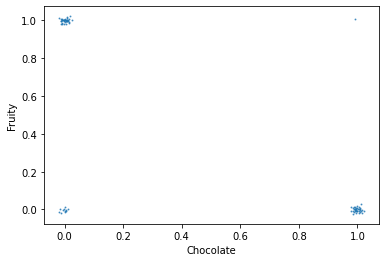

In [ ]:
plt.scatter(rand_jitter(df['chocolate']), rand_jitter(df['fruity']), alpha=0.7, s=0.9)
plt.xlabel('Chocolate')
plt.ylabel('Fruity')
plt.show()


##show all unique features, their frequencies and mean win percents

In [ ]:
# To dummy_encoded_features
dummy_encoded_features = df[['chocolate', 'fruity', 'caramel', 'peanutyalmondy','nougat', 'crispedricewafer', 'hard', 'bar', 'pluribus']]
# add 'no_features' column 
dummy_encoded_features['no_features'] = np.zeros(85)
dummy_encoded_features.loc[((dummy_encoded_features == 0).all(axis=1)), 'no_features'] = 1

# add column for counting frequency
dummy_encoded_features['frequency'] = np.ones(85)

# add winpercent column
dummy_encoded_features['winpercent'] = df['winpercent']

freq_feature_table = dummy_encoded_features.groupby(['chocolate', 'fruity', 'caramel', 'peanutyalmondy','nougat', 'crispedricewafer', 'hard', 'bar', 'pluribus', 'no_features'], as_index=False).agg({'frequency':'size', 'winpercent':'mean'}).rename(columns={'winpercent':'mean_winpercent'})
freq_feature_table.sort_values(by=['frequency', 'mean_winpercent'], ascending=False).reset_index(drop=True)

<ipython-input-8-d9dbe888efc9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dummy_encoded_features['no_features'] = np.zeros(85)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
<ipython-input-8-d9dbe888efc9>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,no_features,frequency,mean_winpercent
0,0,1,0,0,0,0,0,0,1,0.0,19,46.662800
1,0,1,0,0,0,0,1,0,1,0.0,7,42.136329
2,1,0,0,0,0,0,0,0,1,0.0,6,49.585871
3,0,1,0,0,0,0,0,0,0,0.0,5,43.882512
4,0,1,0,0,0,0,1,0,0,0.0,5,38.417954
5,1,0,0,0,0,0,0,1,0,0.0,4,53.302470
6,1,0,0,1,0,0,0,0,0,0.0,3,79.644816
7,1,0,0,1,0,0,0,0,1,0.0,3,71.461276
8,1,0,0,0,0,1,0,1,0,0.0,3,68.507920
9,1,0,0,1,0,0,0,1,0,0.0,3,58.536546


We note that in the table above, there are candies that indeed do not possess any of the features represented by the columns. We create a 'no_feature' column for the sake of convenience for our data analysis later. These 'no_feature' candies will form the conditional mean of win percent when we obtain the intercept of our linear regression in the next analysis.

# First analysis with candies with no features as basis

In [ ]:
y = np.asarray(df['winpercent'])
X = np.asarray(dummy_encoded_features.drop(['frequency', 'no_features', 'winpercent'], axis=1))
X = sm.add_constant(X)
model = sm.OLS(endog = y, exog=X) # (y,X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.515
Model:                            OLS   Adj. R-squared:                  0.457
Method:                 Least Squares   F-statistic:                     8.842
Date:                Sat, 10 Dec 2022   Prob (F-statistic):           6.05e-09
Time:                        11:29:37   Log-Likelihood:                -317.92
No. Observations:                  85   AIC:                             655.8
Df Residuals:                      75   BIC:                             680.3
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         35.0155      4.078      8.586      0.0

Based on the results obtained;
- p-value is less than the significance value, alpha = 0.05. This means that there is sufficient evidence to reject the null hypothesis. The null hypothesis states that R-squared = 0. We conclude that the alternative hypothesis, R-squared > 0, is true.

- R-squared = 0.515 indicates the proportion of how features like (chocolate, peanutalmondy, ...) accounts for the win percentage. 

- we observe that the conditional mean, also the intercept (where the candy is neither chocolate, wafer, or any of the stated features... based) will have a win percent of 35%.

- the other coefficients represent the slope with the associated feature of a candy. By summing these values with the constant, say chocolate, it means that candies with chocolate in them have a higher win percent by 19.9 percentage points. 

- Lastly, the t-values that are associated with the coefficients is a test where the null hypothesis states that the means are the same. If the p-value is small it means that there is sufficient evidence to reject the null hypothesis and add these values to the intercept. With a significance level of 0.05, we can thus consider x1,x2,x4 and x6 (chocoalte, fruity, peanutyalmondy and crispedricewafer) as variables that contribute to the win percent.

In [ ]:
feature_rank = pd.DataFrame(np.concatenate([[results.params[1:]], [results.pvalues[1:]]], axis=0).T, index = list(dummy_encoded_features.drop(['frequency', 'no_features', 'winpercent'], axis=1).columns), columns= ["Difference in mean when said feature exists in candy", 'p-value'])
index_german = ['schokoladig', 'fruchtig', 'karamell', 'erdnuss-mandel', 'nougat', 'keks', 'hart', 'riegel', 'multi']
feature_rank.index = index_german
feature_rank = feature_rank.sort_values(by = ["Difference in mean when said feature exists in candy"], ascending = False)
feature_rank

,Difference in mean when said feature exists in candy,p-value
schokoladig,19.905795,0.000002
fruchtig,10.267732,0.008332
erdnuss-mandel,10.141017,0.006124
keks,8.991549,0.095638
karamell,3.384282,0.350647
nougat,2.416252,0.672293
multi,-0.159917,0.957792
riegel,-0.721966,0.882561
hart,-4.872560,0.160716


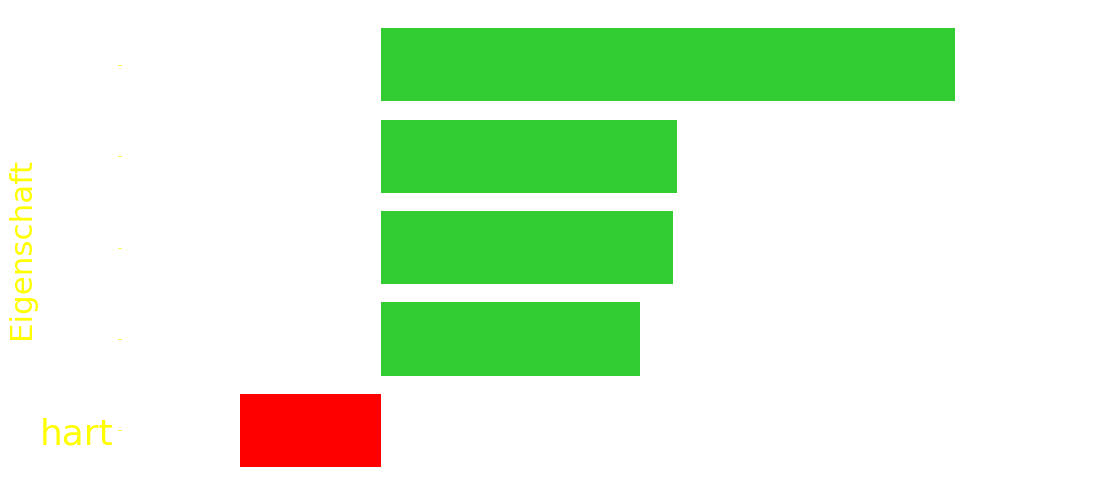

In [ ]:
relevant_features = feature_rank[feature_rank['p-value'] <=0.2] # let significance level be 0.1
relevant_features = relevant_features.sort_values(by = ["Difference in mean when said feature exists in candy"], ascending = True)

fig, ax = plt.subplots(figsize = (15.5,7))
y_pos = range(relevant_features.shape[0])
fontsize = 36

#relevant_features.drop(['p-value'], axis=1).sort_values(by = ["Difference in mean when said feature exists in candy"], ascending = True).plot(kind = "barh", color = "steelblue", legend = False, ax = ax)

color = ['red' if y<0 else 'limegreen' for y in relevant_features["Difference in mean when said feature exists in candy"].sort_values(ascending = True)]
ax.barh(y_pos, relevant_features["Difference in mean when said feature exists in candy"].sort_values(ascending = True),  align='center', color = color)
ax.set_yticks(y_pos)
ax.set_yticklabels(['hart', '', '', '', ''])
ax.set_ylabel('Eigenschaft', fontsize=fontsize-5, color='yellow')
ax.set_xlim(left=-9,right=25)
ax.axes.get_xaxis().set_visible(False)
#ax.set_title('Eigenschaften von Süßigkeit, die den Mittelwert des Gewinnprozentsatzes erhöhen', fontsize=20, color = 'yellow') # (in abnehmender Reihenfolge)
ax.tick_params(axis='both', which='major', labelsize=30)


ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.label.set_color('yellow')
ax.tick_params(axis='y', colors='yellow', labelsize=fontsize)



fig.tight_layout()
fig.savefig('no_feature_basis_novalue.svg',transparent=True)
plt.show()

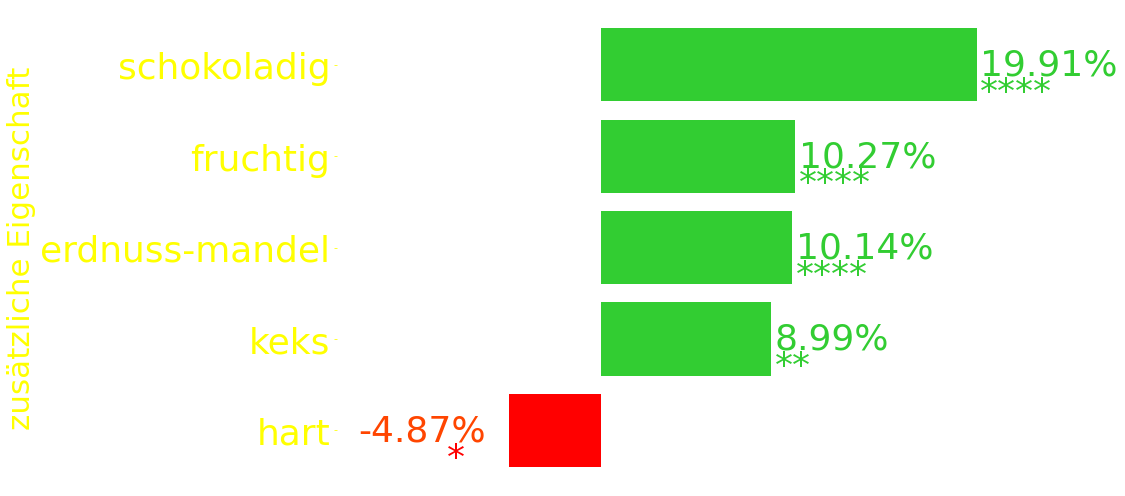

In [ ]:
relevant_features = feature_rank[feature_rank['p-value'] <=0.2] # let significance level be 0.1
relevant_features = relevant_features.sort_values(by = ["Difference in mean when said feature exists in candy"], ascending = True)

fig, ax = plt.subplots(figsize = (15.5,7))
y_pos = range(relevant_features.shape[0])
fontsize = 36

#relevant_features.drop(['p-value'], axis=1).sort_values(by = ["Difference in mean when said feature exists in candy"], ascending = True).plot(kind = "barh", color = "steelblue", legend = False, ax = ax)

color = ['red' if y<0 else 'limegreen' for y in relevant_features["Difference in mean when said feature exists in candy"].sort_values(ascending = True)]
ax.barh(y_pos, relevant_features["Difference in mean when said feature exists in candy"].sort_values(ascending = True),  align='center', color = color)
ax.set_yticks(y_pos)
ax.set_yticklabels(relevant_features.index)
ax.set_ylabel('zusätzliche Eigenschaft', fontsize=fontsize-5, color='yellow')
ax.set_xlim(left=-14,right=25)
ax.axes.get_xaxis().set_visible(False)
#ax.set_title('Eigenschaften von Süßigkeit, die den Mittelwert des Gewinnprozentsatzes erhöhen', fontsize=20, color = 'yellow') # (in abnehmender Reihenfolge)
ax.tick_params(axis='both', which='major', labelsize=30)

# plotting the * and values , where * = 0.2, ** = 0.1 and *** = 0.05, **** = 0.01 significance level
# the greater the number of stars, the more confident that it will add to the mean win percentage
for i, p, v in zip(range(len(relevant_features["p-value"])), relevant_features["p-value"],relevant_features["Difference in mean when said feature exists in candy"]):
    if v>0:
      plt.text(v+0.2, i, str(round(v, 2))+'{}'.format('%'), color='limegreen', va="center", fontsize=fontsize)
      if p<=0.01:
        plt.text(v+0.2, i-0.3, '****', color='limegreen', va="center", fontsize=fontsize)
      elif p<=0.05:
        plt.text(v+0.2, i-0.3, '***', color='limegreen', va="center", fontsize=fontsize)
      elif p<=0.1:
        plt.text(v+0.2, i-0.3, '**', color='limegreen', va="center", fontsize=fontsize)
      elif p<=0.2:
        plt.text(v+0.2, i-0.3, '*', color='limegreen', va="center", fontsize=fontsize)

    else: 
      plt.text(v-8, i, str(round(v, 2))+'{}'.format('%'), color='orangered', va="center", fontsize=fontsize)
      if p<=0.01:
        plt.text(v-3.3, i-0.3, '****', color='red', va="center", fontsize=fontsize)
      elif p<=0.05:
        plt.text(v-3.3, i-0.3, '***', color='red', va="center", fontsize=fontsize)
      elif p<=0.1:
        plt.text(v-3.3, i-0.3, '**', color='red', va="center", fontsize=fontsize)
      elif p<=0.2:
        plt.text(v-3.3, i-0.3, '*', color='red', va="center", fontsize=fontsize)


ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.label.set_color('yellow')
ax.tick_params(axis='y', colors='yellow', labelsize=fontsize)



fig.tight_layout()
fig.savefig('no_feature_basis.svg',transparent=True)
plt.show()

From the difference in conditional mean, we can therefore conclude that chocolate based candies will have a conditional mean winpercent of 54.9%, while fruit based candies will have a conditional mean winpercent of 45.2%, crisped-rice wafer based candies have a conditional mean winpercent of 43.99%. It would thus be more advisable if the team takes on a chocolate and crisped-rice wafer based candy.

## Assumptions check in first model 

Assumptions to check before we continue on multiple regression:
- [X] There is a linear relationship between dependent and independent variables.
- [X] The independent variables are not highly correlated with each other. Use the Variance Inflation Factor to check this assumption.
- [ ] The variance of residuals is constant. 
- [X] Models assume that observations are independent of one another.
- [X] Multivariate normality is when residuals are normally distributed.

In [ ]:
#Assumption 2 Variance Inflation Factor - check that independent variables are not highly correlated with each other. 
dummy_encoded_features = df[['chocolate', 'fruity', 'caramel', 'peanutyalmondy','nougat', 'crispedricewafer', 'hard', 'bar', 'pluribus']]
dummy_encoded_features_arr = sm.add_constant(dummy_encoded_features)

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(dummy_encoded_features_arr.values, i) for i in range(dummy_encoded_features.shape[1])]
vif["features"] = dummy_encoded_features.columns
vif.round(1)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,VIF Factor,features
0,12.0,chocolate
1,2.7,fruity
2,2.6,caramel
3,1.3,peanutyalmondy
4,1.3,nougat
5,1.8,crispedricewafer
6,1.5,hard
7,1.2,bar
8,3.2,pluribus


While chocolate as a variable does have a high VIF Factor of 12 as compared to the rest, it is reasonably range to still include it in our analysis of Multiple Regression later.  

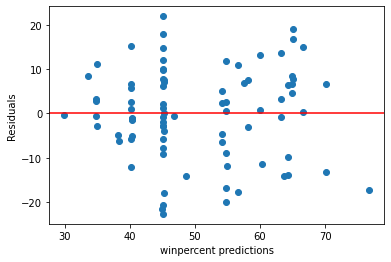

In [ ]:
# Assumption 3- check that variance of residuals is constant. i.e. residuals should be randomly spread out centered around 0 on y-axis.

winpercent_pred = model.predict(results.params)
model1_residuals = results.resid

plt.scatter(winpercent_pred, model1_residuals)
plt.ylabel('Residuals')
plt.xlabel('winpercent predictions')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

In [ ]:
np.mean(model1_residuals)

6.562071147902102e-15

Residuals are randomly scattered centered around 0. The mean of the residuals is also 0. Hence, we can conclude that the assumption of homoscedasticity is satisfied.

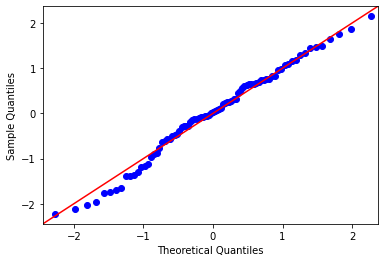

In [ ]:
# Assumption 5 - check for normally distributed residuals using qqplot.
sm.qqplot(model1_residuals, line = "45", fit = True)
plt.show()

Since the data lies approximately on the 45 degree angle straight line, one can conclude that the residuals are normally distributed. Assumption 5 is satisfied.

# Second analysis with candies with chocolate only as a feature as basis

In [ ]:
dummy_encoded_features.columns

Index(['chocolate', 'fruity', 'caramel', 'peanutyalmondy', 'nougat',
       'crispedricewafer', 'hard', 'bar', 'pluribus', 'no_features',
       'frequency', 'winpercent'],
      dtype='object')

In [ ]:
y = np.asarray(df['winpercent'])
X = np.asarray(dummy_encoded_features.drop(['frequency', 'chocolate', 'winpercent'], axis=1))
X = sm.add_constant(X)
model = sm.OLS(y, X) # (y,X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.354
Model:                            OLS   Adj. R-squared:                  0.276
Method:                 Least Squares   F-statistic:                     4.560
Date:                Fri, 09 Dec 2022   Prob (F-statistic):           8.29e-05
Time:                        11:36:16   Log-Likelihood:                -330.11
No. Observations:                  85   AIC:                             680.2
Df Residuals:                      75   BIC:                             704.6
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         48.4511      4.350     11.138      0.0

In [ ]:
feature_rank = pd.DataFrame(np.concatenate([[results.params[1:]], [results.pvalues[1:]]], axis=0).T, index = list(dummy_encoded_features.drop(['frequency', 'chocolate', 'winpercent'], axis=1).columns), columns= ["Difference in mean when said feature exists in candy", 'p-value'])
index_german = ['fruchtig', 'karamell', 'erdnuss-mandel', 'nougat', 'keks', 'hart', 'riegel', 'multi', 'keine']
feature_rank.index = index_german
feature_rank.sort_values(by = ["Difference in mean when said feature exists in candy"], ascending = False)

,Difference in mean when said feature exists in candy,p-value
erdnuss-mandel,11.825042,0.006025
keks,11.390340,0.066829
riegel,4.698355,0.404586
karamell,1.776629,0.673211
nougat,0.819375,0.900907
multi,-1.043083,0.776636
fruchtig,-1.559545,0.677604
hart,-6.152603,0.127032
keine,-9.262263,0.350728


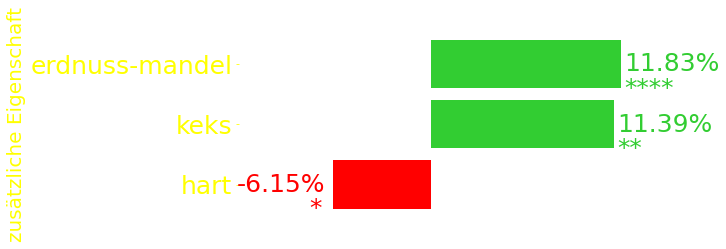

In [ ]:
relevant_features = feature_rank[feature_rank['p-value'] <=0.2] # let significance level be 0.1
relevant_features = relevant_features.sort_values(by = ["Difference in mean when said feature exists in candy"], ascending = True)

fig, ax = plt.subplots(figsize = (10,3.5))
y_pos = range(relevant_features.shape[0])
fontsize=25
color = ['r' if y<0 else 'limegreen' for y in relevant_features["Difference in mean when said feature exists in candy"].sort_values(ascending = True)]
ax.barh(y_pos, relevant_features["Difference in mean when said feature exists in candy"].sort_values(ascending = True),  align='center', color = color)
ax.set_yticks(y_pos)
ax.set_yticklabels(relevant_features.index)
ax.set_ylabel('zusätzliche Eigenschaft', fontsize=fontsize-5, color = 'yellow')
ax.set_xlim([-12, 15])
#ax.set_title('Schokolade als grundlegende Eigenschaft', fontsize=20, color = 'yellow')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.axes.get_xaxis().set_visible(False)

#for i, v in enumerate(relevant_features["Difference in mean when said feature exists in candy"]):
#    plt.text(v+0.2, i, str(round(v, 2)), color='black', va="center", fontsize=20)

# plotting the * and values , where * = 0.2, ** = 0.1 and *** = 0.05, **** = 0.01 significance level
# the greater the number of stars, the more confident that it will add to the mean win percentage
for i, p, v in zip(range(len(relevant_features["p-value"])), relevant_features["p-value"],relevant_features["Difference in mean when said feature exists in candy"]):
    if v>0:
      plt.text(v+0.2, i, str(round(v, 2))+'{}'.format('%'), color='limegreen', va="center", fontsize=fontsize)
      if p<=0.01:
        plt.text(v+0.2, i-0.4, '****', color='limegreen', va="center", fontsize=fontsize)
      elif p<=0.05:
        plt.text(v+0.2, i-0.4, '***', color='limegreen', va="center", fontsize=fontsize)
      elif p<=0.1:
        plt.text(v+0.2, i-0.4, '**', color='limegreen', va="center", fontsize=fontsize)
      elif p<=0.2:
        plt.text(v+0.2, i-0.4, '*', color='limegreen', va="center", fontsize=fontsize)

    else: 
      plt.text(v-6, i, str(round(v, 2))+'{}'.format('%'), color='red', va="center", fontsize=fontsize)
      if p<=0.01:
        plt.text(v-3, i-0.4, '****', color='red', va="center", fontsize=fontsize)
      elif p<=0.05:
        plt.text(v-3, i-0.4, '***', color='red', va="center", fontsize=fontsize)
      elif p<=0.1:
        plt.text(v-2, i-0.4, '**', color='red', va="center", fontsize=fontsize)
      elif p<=0.2:
        plt.text(v-1.5, i-0.4, '*', color='red', va="center", fontsize=fontsize)

ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.label.set_color('yellow')
ax.tick_params(axis='y', colors='yellow', labelsize=fontsize)

fig.tight_layout()
fig.savefig('chocolate_basis.svg',transparent=True)
plt.show()

In [ ]:
35+19.9+10.1

65.0

In [ ]:
46.6495+12.54

59.1895

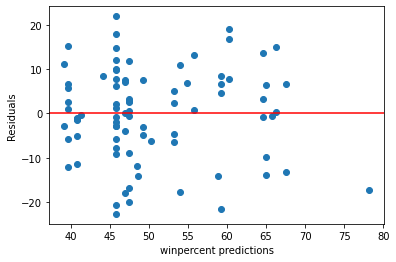

In [ ]:
# Assumption 3- check that variance of residuals is constant. i.e. residuals should be randomly spread out centered around 0 on y-axis.

winpercent_pred = model.predict(results.params)
model2_residuals = results.resid

plt.scatter(winpercent_pred, model1_residuals)
plt.ylabel('Residuals')
plt.xlabel('winpercent predictions')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

In [ ]:
np.mean(model2_residuals)

2.4576419330996407e-14

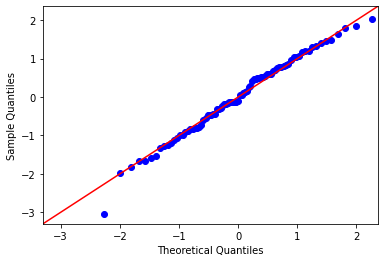

In [ ]:
# Assumption 5 - check for normally distributed residuals using qqplot.
sm.qqplot(model2_residuals, line = "45", fit = True)
plt.show()

# Third analysis with candies with fruity only as a feature as basis

In [ ]:
y = np.asarray(df['winpercent'])
X = np.asarray(dummy_encoded_features.drop(['frequency', 'fruity', 'winpercent'], axis=1))
X = sm.add_constant(X)
model = sm.OLS(y, X) # (y,X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.469
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                     7.355
Date:                Fri, 09 Dec 2022   Prob (F-statistic):           1.33e-07
Time:                        11:36:53   Log-Likelihood:                -321.77
No. Observations:                  85   AIC:                             663.5
Df Residuals:                      75   BIC:                             688.0
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         43.2171      3.358     12.871      0.0

In [ ]:
feature_rank = pd.DataFrame(np.concatenate([[results.params[1:]], [results.pvalues[1:]]], axis=0).T, index = list(dummy_encoded_features.drop(['frequency','fruity', 'winpercent'], axis=1).columns), columns= ["Difference in mean when said feature exists in candy", 'p-value'])
feature_rank.sort_values(by = ["Difference in mean when said feature exists in candy"], ascending = False)

,Difference in mean when said feature exists in candy,p-value
chocolate,13.759084,0.000120
crispedricewafer,8.942415,0.112922
peanutyalmondy,8.225499,0.029377
nougat,2.414091,0.686294
caramel,1.202549,0.745922
pluribus,-0.560446,0.866063
bar,-1.585246,0.759148
hard,-3.406705,0.347237
no_features,-4.028353,0.644659


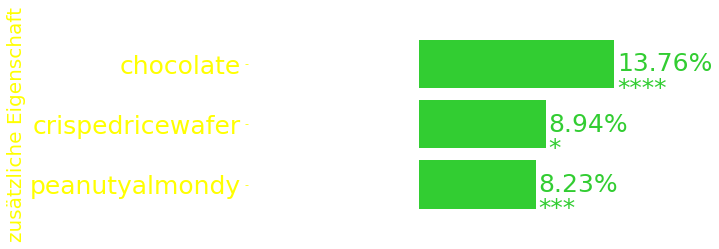

In [ ]:
relevant_features = feature_rank[feature_rank['p-value'] <=0.2] # let significance level be 0.1
relevant_features = relevant_features.sort_values(by = ["Difference in mean when said feature exists in candy"], ascending = True)

fig, ax = plt.subplots(figsize = (10,3.5))
y_pos = range(relevant_features.shape[0])
fontsize=25
color = ['r' if y<0 else 'limegreen' for y in relevant_features["Difference in mean when said feature exists in candy"].sort_values(ascending = True)]
ax.barh(y_pos, relevant_features["Difference in mean when said feature exists in candy"].sort_values(ascending = True),  align='center', color = color)
ax.set_yticks(y_pos)
ax.set_yticklabels(relevant_features.index)
ax.set_ylabel('zusätzliche Eigenschaft', fontsize=fontsize-5, color = 'yellow')
ax.set_xlim([-12, 15])
#ax.set_title('Schokolade als grundlegende Eigenschaft', fontsize=20, color = 'yellow')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.axes.get_xaxis().set_visible(False)

#for i, v in enumerate(relevant_features["Difference in mean when said feature exists in candy"]):
#    plt.text(v+0.2, i, str(round(v, 2)), color='black', va="center", fontsize=20)

# plotting the * and values , where * = 0.2, ** = 0.1 and *** = 0.05, **** = 0.01 significance level
# the greater the number of stars, the more confident that it will add to the mean win percentage
for i, p, v in zip(range(len(relevant_features["p-value"])), relevant_features["p-value"],relevant_features["Difference in mean when said feature exists in candy"]):
    if v>0:
      plt.text(v+0.2, i, str(round(v, 2))+'{}'.format('%'), color='limegreen', va="center", fontsize=fontsize)
      if p<=0.01:
        plt.text(v+0.2, i-0.4, '****', color='limegreen', va="center", fontsize=fontsize)
      elif p<=0.05:
        plt.text(v+0.2, i-0.4, '***', color='limegreen', va="center", fontsize=fontsize)
      elif p<=0.1:
        plt.text(v+0.2, i-0.4, '**', color='limegreen', va="center", fontsize=fontsize)
      elif p<=0.2:
        plt.text(v+0.2, i-0.4, '*', color='limegreen', va="center", fontsize=fontsize)

    else: 
      plt.text(v-6, i, str(round(v, 2))+'{}'.format('%'), color='red', va="center", fontsize=fontsize)
      if p<=0.01:
        plt.text(v-3, i-0.4, '****', color='red', va="center", fontsize=fontsize)
      elif p<=0.05:
        plt.text(v-3, i-0.4, '***', color='red', va="center", fontsize=fontsize)
      elif p<=0.1:
        plt.text(v-2, i-0.4, '**', color='red', va="center", fontsize=fontsize)
      elif p<=0.2:
        plt.text(v-1.5, i-0.4, '*', color='red', va="center", fontsize=fontsize)

ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.label.set_color('yellow')
ax.tick_params(axis='y', colors='yellow', labelsize=fontsize)

fig.tight_layout()
#fig.savefig('chocolate_basis.svg',transparent=True)
plt.show()

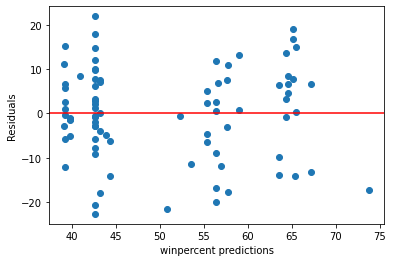

In [ ]:
# Assumption 3- check that variance of residuals is constant. i.e. residuals should be randomly spread out centered around 0 on y-axis.

winpercent_pred = model.predict(results.params)
model3_residuals = results.resid

plt.scatter(winpercent_pred, model1_residuals)
plt.ylabel('Residuals')
plt.xlabel('winpercent predictions')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

In [ ]:
np.mean(model3_residuals)

-4.087710562196341e-14

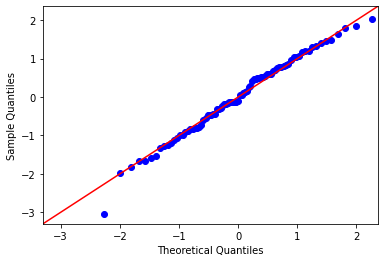

In [ ]:
# Assumption 5 - check for normally distributed residuals using qqplot.
sm.qqplot(model2_residuals, line = "45", fit = True)
plt.show()

# Fourth Analysis, if chocolate and peanuty-almondy as basis


In [ ]:
y = np.asarray(df['winpercent'])
X = np.asarray(dummy_encoded_features.drop(['frequency', 'chocolate', 'peanutyalmondy', 'winpercent'], axis=1))
X = sm.add_constant(X)
model = sm.OLS(y, X) # (y,X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.285
Model:                            OLS   Adj. R-squared:                  0.210
Method:                 Least Squares   F-statistic:                     3.783
Date:                Fri, 09 Dec 2022   Prob (F-statistic):           0.000882
Time:                        09:40:25   Log-Likelihood:                -334.41
No. Observations:                  85   AIC:                             686.8
Df Residuals:                      76   BIC:                             708.8
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         53.5176      4.142     12.921      0.0

In [ ]:
feature_rank = pd.DataFrame(np.concatenate([[results.params[1:]], [results.pvalues[1:]]], axis=0).T, index = list(dummy_encoded_features.drop(['frequency', 'chocolate', 'peanutyalmondy', 'winpercent'], axis=1).columns), columns= ["Difference in mean when said feature exists in candy", 'p-value'])
feature_rank.sort_values(by = ["Difference in mean when said feature exists in candy"], ascending = False)

,Difference in mean when said feature exists in candy,p-value
crispedricewafer,9.132433,0.154178
bar,4.429410,0.451803
nougat,1.992298,0.771620
caramel,0.197059,0.963951
pluribus,-2.525871,0.506997
fruity,-5.232124,0.157069
hard,-7.140084,0.089461
no_features,-14.328772,0.161534
